In [1]:
!nvidia-smi

Thu Jan 23 16:37:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   27C    P8    13W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   26C    P8     6W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
from itertools import product
import glob

def target_preprocessings(phase_a_switch = [1, 1, 1], phase_b_switch = True, mode = 'load'):
    """
    phase_a_switch = [1, 1, 1], [0, 0 ,1], [1, 1, 0].... 
    that means [flip, rotate, blur_sharp]
    """
    phase0 = ['_c']
    phase1 = {1: ['-', 'f'], 0: ['-']}
    phase2 = {1: ['-', 'r1', 'r2', 'r3'], 0: ['-']}
    phase3 = {1: ['-', 'ab', 'mb', 'eh'], 0: ['-']}
    phase4 = ['s_-30_v_30', 's_-30_v_-30', 's_30_v_-30', 's_30_v_30']
    
    if mode == 'load':
        phase_a_items = [phase1[phase_a_switch[0]], phase2[phase_a_switch[1]], phase3[phase_a_switch[2]]]
    elif mode == 'preprocessing':
        phase_a_items = [phase0, phase1[phase_a_switch[0]], phase2[phase_a_switch[1]], phase3[phase_a_switch[2]]]
    
    phase_a = []
    for i in list(product(*phase_a_items)):
        phase_a.append('_'.join(i))

    if not phase_b_switch != True:
        phase_b = []
        for i in list(product(*[phase_a, phase4])):
            phase_b.append('_'.join(i))
        return list(np.hstack([phase_a, phase_b]))
    else:
        return phase_a 

class ce_load_dataset:
    def __init__(self, phase, data, pre_a, pre_b, img_ch = 'bgr', ext_name = True):
        self.phase = phase        # 'train' or 'test'
        self.data = data          # 'sm', 'sm_core', 'sm_v2', 'sm_x160', ...
        self.pre_a = pre_a        # [1, 1, 1], [0, 0 ,1], [1, 1, 0].... 
        self.pre_b = pre_b        # True or False
        self.img_ch = img_ch      # 'bgr', 'rgb', and 'hsv'
        self.ext_name = ext_name  # True or False

    def load_path(self, cls, les, data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'):
        """
        phase = 'train', 'test'
        cls: [les]  
          'n': ['neg']
          'h': ['redspot', 'angio', 'active'], 
          'd': ['ero', 'ulc', 'str'],
          'p': ['amp', 'lym', 'tum']}
        pre_a[0] must be 0
        """
        lesions = dict(neg = 'negative', 
                       redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                       ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                       amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
        classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

        path = os.path.join(data_dir, self.data, self.phase, classes[cls], lesions[les])
        pathlist = glob.glob(path + '/*.jpg')
        if self.pre_b != True:
            path_in_phase = []
            for p in pathlist:
                name = os.path.basename(p)
                if (name.split('c_')[-1])[:-4] in target_preprocessings(self.pre_a, self.pre_b):
                    path_in_phase.append(p)   
            return np.asarray(path_in_phase)
        else:
            return np.asarray(pathlist)

    def load_image_from_path(self, pathlist,image_ch = 'bgr', extract_name = False):
        data = []
        for i in pathlist:
            temp = cv2.imread(i)
            if image_ch == 'bgr':
                pass
            elif image_ch == 'rgb':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            elif image_ch == 'hsv':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
            data.append(temp)
        if extract_name != False:
            name = []
            for i in pathlist:
                name.append(os.path.basename(i))
            return np.asarray(data), np.asarray(name)
        else:
            return np.asarray(data) 

    def load_data(self, cls, les):
        pathlist = self.load_path(cls, les)
        return  self.load_image_from_path(pathlist, image_ch = self.img_ch, extract_name = self.ext_name)

In [4]:
ce = ce_load_dataset(phase = 'test', data = 'sm_x160_v2', pre_a = [0, 0, 0], pre_b = False)

In [5]:
neg_testset = ce.load_data('n', 'neg')
redspot_testset = ce.load_data('h', 'redspot')
angio_testset = ce.load_data('h', 'angio')
active_testset = ce.load_data('h', 'active')
ero_testset = ce.load_data('d', 'ero')
ulcer_testset = ce.load_data('d', 'ulcer')
str_testset = ce.load_data('d', 'str')

neg_label = one_hot(neg_testset[0], 0)
redspot_label = one_hot(redspot_testset[0], 1)
angio_label = one_hot(angio_testset[0], 1)
active_label = one_hot(active_testset[0], 1)
ero_label = one_hot(ero_testset[0], 1)
ulcer_label = one_hot(ulcer_testset[0], 1)
str_label = one_hot(str_testset[0], 1)

print("negative:",neg_testset[0].shape, neg_label.shape)
print("red spot:",redspot_testset[0].shape, redspot_label.shape)
print("angioectasia:",angio_testset[0].shape, angio_label.shape)
print("active_bleeding:",active_testset[0].shape, active_label.shape)
print("erosion:",ero_testset[0].shape, ero_label.shape)
print("ulcer:",ulcer_testset[0].shape, ulcer_label.shape)
print("stricture:",str_testset[0].shape, str_label.shape)

negative: (1562, 512, 512, 3) (1562, 2)
red spot: (139, 512, 512, 3) (139, 2)
angioectasia: (5, 512, 512, 3) (5, 2)
active_bleeding: (108, 512, 512, 3) (108, 2)
erosion: (185, 512, 512, 3) (185, 2)
ulcer: (183, 512, 512, 3) (183, 2)
stricture: (26, 512, 512, 3) (26, 2)


In [6]:
neg_testset[1]

array(['AJ___02-08-16___1015395__c_-_-_-.jpg',
       'DJ___01-58-32___1014228__c_-_-_-.jpg',
       'DJ___01-59-21___1014325__c_-_-_-.jpg', ...,
       '희정___04-45-38___2047831__c_-_-_-.jpg',
       '희정___05-17-56___2052919__c_-_-_-.jpg',
       '희정___05-19-44___2053248__c_-_-_-.jpg'], dtype='<U37')

# Model Inference

In [7]:
nh_list = sorted([i[:-5] for i in os.listdir('./model/X160_v2') if 'meta' in i and 'X160_v2_fr_NH' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model/X160_v2') if 'meta' in i and 'X160_v2_fr_ND' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model/X160_v2') if 'meta' in i and 'X160_v2_fr_B' in i])

In [8]:
nh_list

['X160_v2_fr_NH_2001221058_50_t_acc_0.61_v_acc_0.57_t_loss_0.654339_v_loss_0.661346',
 'X160_v2_fr_NH_2001221059_60_t_acc_0.62_v_acc_0.59_t_loss_0.640510_v_loss_0.646441',
 'X160_v2_fr_NH_2001221059_70_t_acc_0.64_v_acc_0.62_t_loss_0.617561_v_loss_0.612800',
 'X160_v2_fr_NH_2001221100_120_t_acc_0.66_v_acc_0.65_t_loss_0.604123_v_loss_0.603338',
 'X160_v2_fr_NH_2001221100_130_t_acc_0.68_v_acc_0.67_t_loss_0.591936_v_loss_0.595910',
 'X160_v2_fr_NH_2001221113_680_t_acc_0.96_v_acc_0.94_t_loss_0.106436_v_loss_0.135259',
 'X160_v2_fr_NH_2001221114_720_t_acc_0.96_v_acc_0.94_t_loss_0.117666_v_loss_0.135050',
 'X160_v2_fr_NH_2001221118_950_t_acc_0.97_v_acc_0.95_t_loss_0.087342_v_loss_0.127448',
 'X160_v2_fr_NH_2001221119_970_t_acc_0.97_v_acc_0.95_t_loss_0.081709_v_loss_0.120918',
 'X160_v2_fr_NH_2001221119_980_t_acc_0.97_v_acc_0.95_t_loss_0.094254_v_loss_0.120345']

In [9]:
nd_list

['X160_v2_fr_ND_2001221112_670_t_acc_0.90_v_acc_0.93_t_loss_0.253066_v_loss_0.203317',
 'X160_v2_fr_ND_2001221113_680_t_acc_0.91_v_acc_0.93_t_loss_0.249935_v_loss_0.187468',
 'X160_v2_fr_ND_2001221113_690_t_acc_0.91_v_acc_0.94_t_loss_0.241648_v_loss_0.184220',
 'X160_v2_fr_ND_2001221119_1010_t_acc_0.91_v_acc_0.93_t_loss_0.229867_v_loss_0.181311',
 'X160_v2_fr_ND_2001221119_1030_t_acc_0.92_v_acc_0.93_t_loss_0.204096_v_loss_0.177270']

In [10]:
b_list

['X160_v2_fr_B_2001221117_810_t_acc_0.92_v_acc_0.91_t_loss_0.186405_v_loss_0.218376',
 'X160_v2_fr_B_2001221117_820_t_acc_0.93_v_acc_0.92_t_loss_0.175372_v_loss_0.210518',
 'X160_v2_fr_B_2001221118_840_t_acc_0.93_v_acc_0.93_t_loss_0.180108_v_loss_0.204246',
 'X160_v2_fr_B_2001221118_850_t_acc_0.94_v_acc_0.93_t_loss_0.178408_v_loss_0.202150',
 'X160_v2_fr_B_2001221118_870_t_acc_0.94_v_acc_0.93_t_loss_0.188479_v_loss_0.196563']

In [12]:
nh_path = './model/X160_v2/' + nh_list[-1]
nd_path = './model/X160_v2/' + nd_list[-1]
b_path = './model/X160_v2/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0123 16:39:01.668637 140193344452352 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [13]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_testset[0], model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_testset[0], model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_testset[0], model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_testset[0], model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_testset[0], model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_testset[0], model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_testset[0], model_type = 'ensemble')

#: 1562 / Inference Time: 00:00:20
#: 139 / Inference Time: 00:00:02
#: 5 / Inference Time: 00:00:00
#: 108 / Inference Time: 00:00:02
#: 185 / Inference Time: 00:00:03
#: 183 / Inference Time: 00:00:03
#: 26 / Inference Time: 00:00:00


In [14]:
neg_b_output = model_prob(B_model, neg_testset[0])
redspot_b_output = model_prob(B_model, redspot_testset[0])
angio_b_output = model_prob(B_model, angio_testset[0])
active_b_output = model_prob(B_model, active_testset[0])
ero_b_output = model_prob(B_model, ero_testset[0])
ulcer_b_output = model_prob(B_model, ulcer_testset[0])
str_b_output  = model_prob(B_model, str_testset[0])

#: 1562 / Inference Time: 00:00:09
#: 139 / Inference Time: 00:00:00
#: 5 / Inference Time: 00:00:00
#: 108 / Inference Time: 00:00:00
#: 185 / Inference Time: 00:00:01
#: 183 / Inference Time: 00:00:01
#: 26 / Inference Time: 00:00:00


In [15]:
h_label = np.vstack([redspot_label, angio_label, active_label])
d_label = np.vstack([ero_label, ulcer_label, str_label])
labels = np.vstack([neg_label, h_label, d_label])

h_b_output = np.vstack([redspot_b_output, angio_b_output, active_b_output])
d_b_output = np.vstack([ero_b_output, ulcer_b_output, str_b_output])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])

h_e_output = np.vstack([redspot_e_output, angio_e_output, active_e_output])
d_e_output = np.vstack([ero_e_output, ulcer_e_output, str_e_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

# Evaluation

In [16]:
cls = classification_metric()

## Accuracy per lesion

In [18]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output, 'negative')
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output, 'red spot')
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output, 'angioectasia')
active_nh_acc = cls.accuracy(active_label, active_nh_output, 'active bleeding')

negative: 96.73 %
red spot: 88.49 %
angioectasia: 100.00 %
active bleeding: 99.07 %


In [19]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output, 'negative')
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output, 'erosion')
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output, 'ulcer')
str_nd_acc = cls.accuracy(str_label, str_nd_output, 'stricture')

negative: 96.73 %
erosion: 91.35 %
ulcer: 79.23 %
stricture: 92.31 %


In [20]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output, 'negative')
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output, 'red spot')
angio_b_acc = cls.accuracy(angio_label, angio_b_output, 'angioectasia')
active_b_acc = cls.accuracy(active_label, active_b_output, 'active bleeding')
ero_b_acc = cls.accuracy(ero_label, ero_b_output, 'erosion')
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output, 'ulcer')
str_b_acc = cls.accuracy(str_label, str_b_output, 'stricture')

negative: 87.32 %
red spot: 90.65 %
angioectasia: 100.00 %
active bleeding: 100.00 %
erosion: 97.30 %
ulcer: 92.90 %
stricture: 100.00 %


In [21]:
h_b_acc = cls.accuracy(h_label, h_b_output, 'hemorrhagic')
d_b_acc = cls.accuracy(d_label, d_b_output, 'depressed')

hemorrhagic: 94.84 %
depressed: 95.43 %


In [22]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output, 'negative')
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output, 'red spot')
angio_e_acc = cls.accuracy(angio_label, angio_e_output, 'angioectasia')
active_e_acc = cls.accuracy(active_label, active_e_output, 'active bleeding')
ero_e_acc = cls.accuracy(ero_label, ero_e_output, 'erosion')
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output, 'ulcer')
str_e_acc = cls.accuracy(str_label, str_e_output, 'stricture')

negative: 94.11 %
red spot: 94.24 %
angioectasia: 100.00 %
active bleeding: 99.07 %
erosion: 92.43 %
ulcer: 86.34 %
stricture: 96.15 %


In [23]:
h_e_acc = cls.accuracy(h_label, h_e_output, 'hemorrhagic')
d_e_acc = cls.accuracy(d_label, d_e_output, 'depressed')

hemorrhagic: 96.43 %
depressed: 89.85 %


## Confusion Matrix

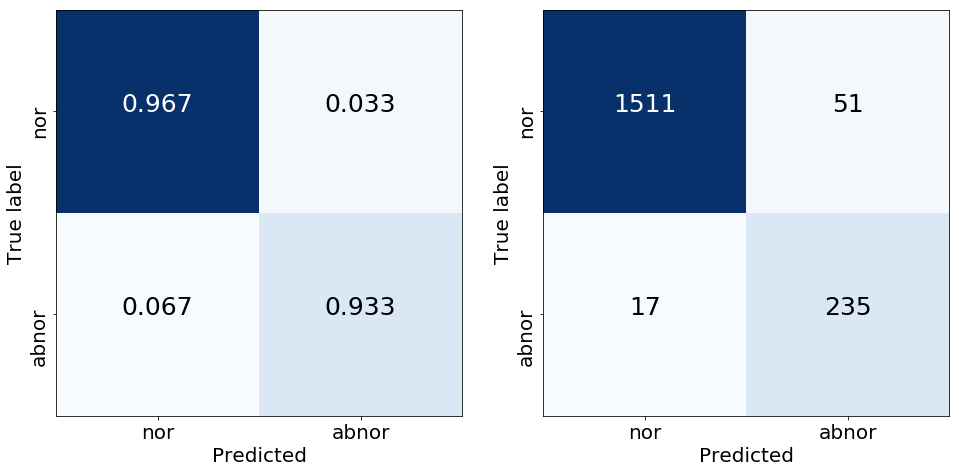

In [24]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
nh_labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(nh_labels, nh_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

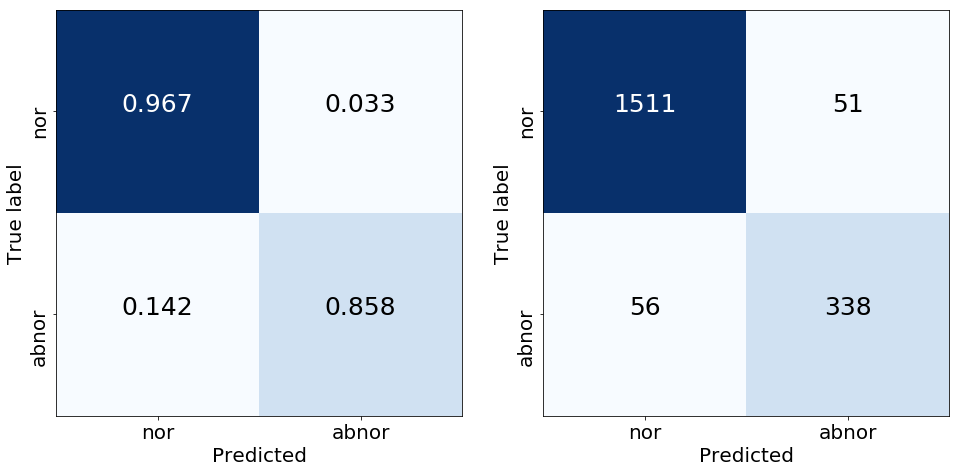

In [25]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
nd_labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(nd_labels, nd_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

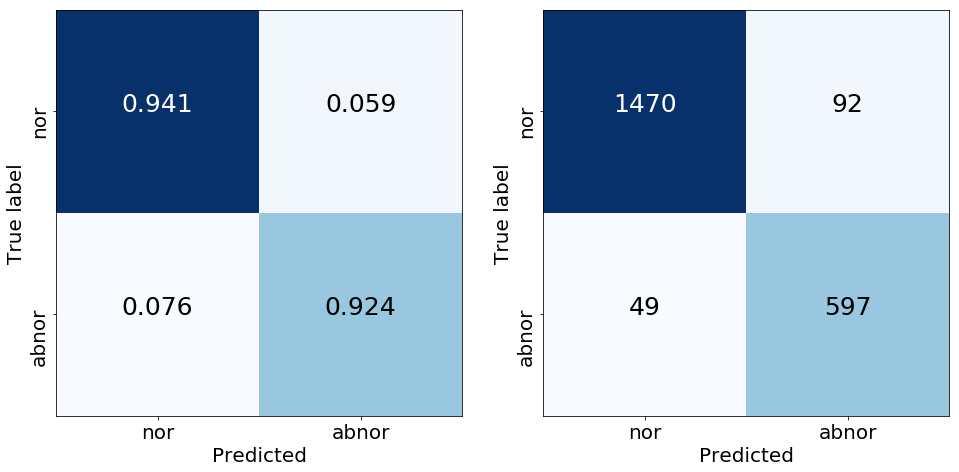

In [26]:
e_CM = cls.con_mat(labels, e_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

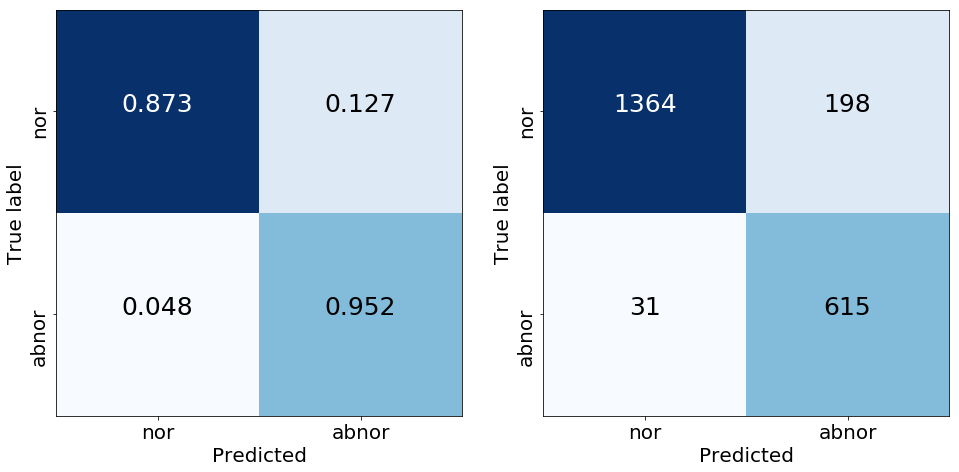

In [27]:
## False cases

b_CM = cls.con_mat(labels, b_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## False cases

In [28]:
testset = np.vstack([neg_testset[0], redspot_testset[0], angio_testset[0], active_testset[0], 
                      ero_testset[0], ulcer_testset[0], str_testset[0]])

filename = np.hstack([neg_testset[1], redspot_testset[1], angio_testset[1], active_testset[1], 
                      ero_testset[1], ulcer_testset[1], str_testset[1]])

In [29]:
def fp_fn_list(name, prob, label):

    pred = np.argmax(prob, axis = 1)
    true = np.argmax(label, axis = 1)

    fp_list, fn_list = [], []
    for n, p, t in zip(name, pred, true):
        if p == 1:
            if p != t:
                fp_list.append(n)
        elif p == 0:
            if p != t:
                fn_list.append(n)
    return np.asarray(fp_list), np.asarray(fn_list)

In [30]:
b_fp_list, b_fn_list = fp_fn_list(name = filename, prob = b_outputs, label = labels)
e_fp_list, e_fn_list = fp_fn_list(name = filename, prob = e_outputs, label = labels)

In [31]:
b_fp_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in b_fp_list])]
b_fn_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in b_fn_list])]

e_fp_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in e_fp_list])]
e_fn_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in e_fn_list])]

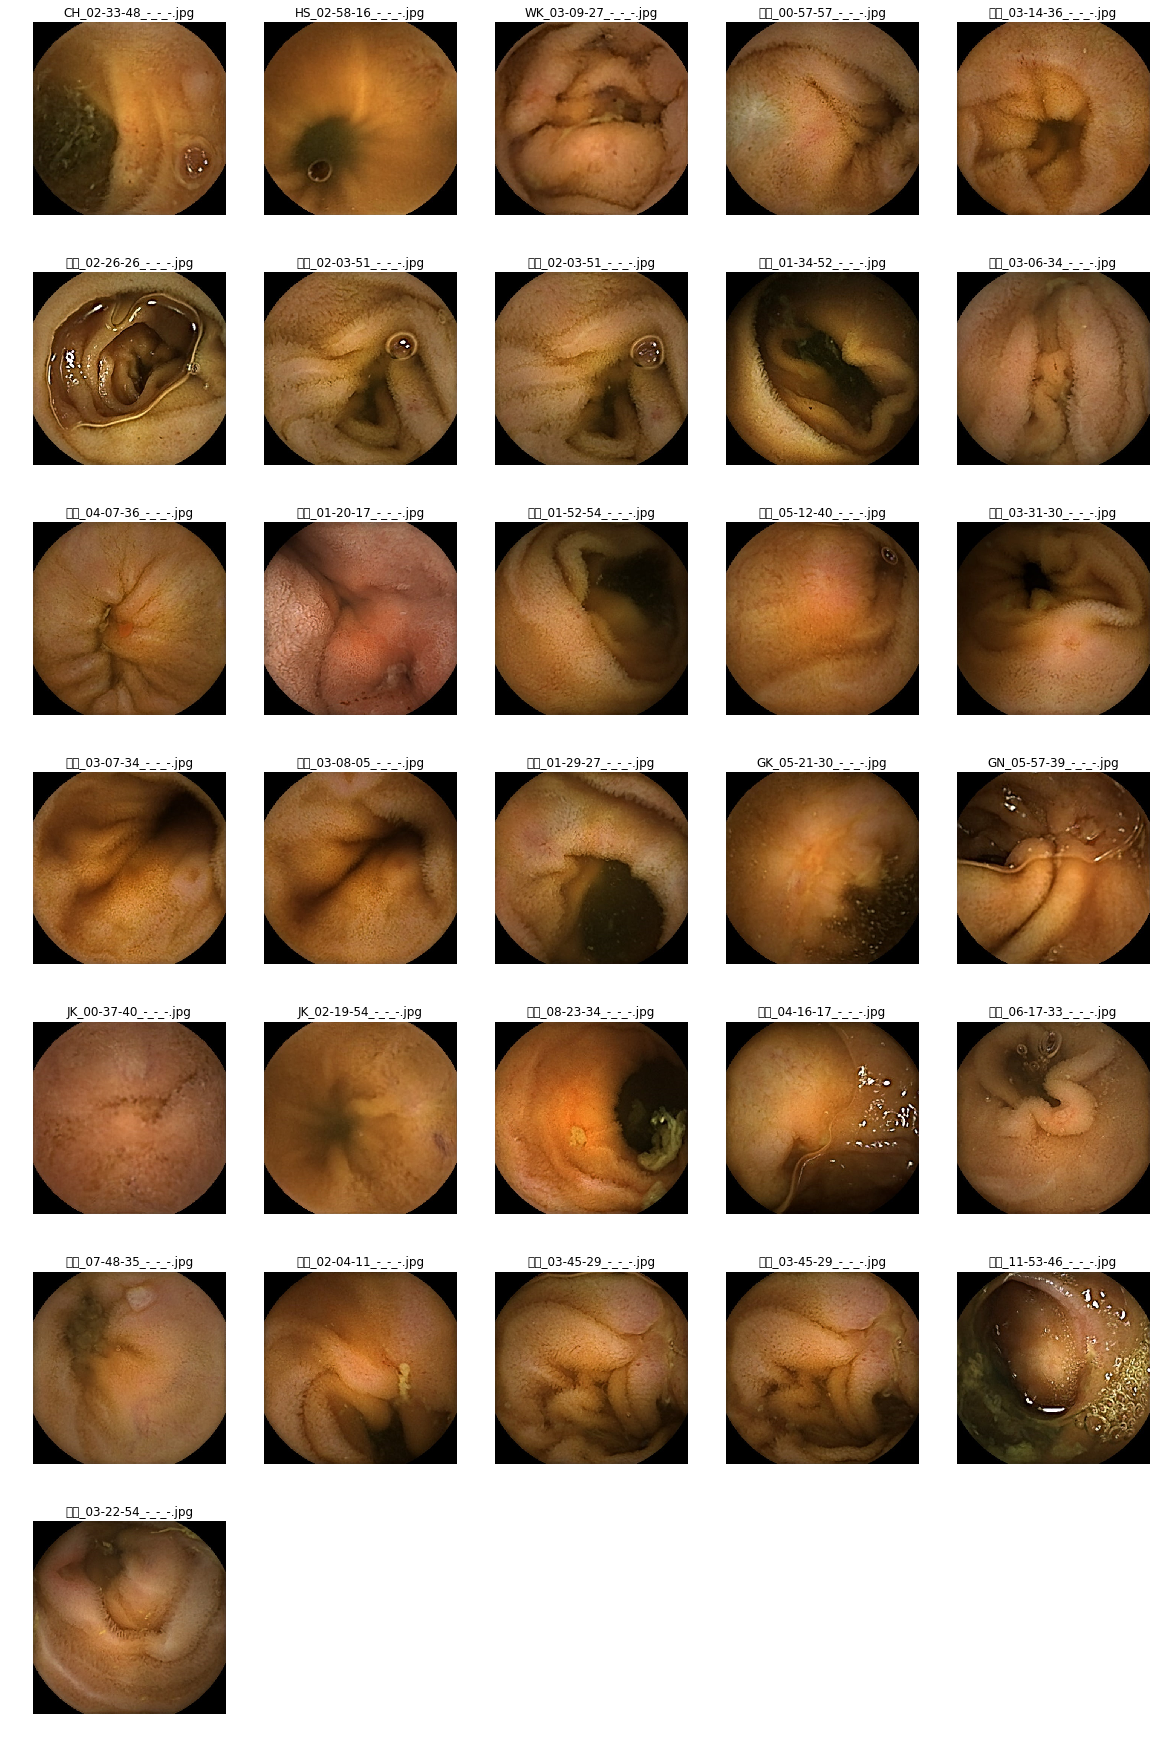

In [32]:
plt.figure(figsize = (20, 36))
for i, name, img in zip(range(len(b_fn_testset)), b_fn_list, b_fn_testset):
    if i+1 > 40:
        break
    plt.subplot(8, 5, i+1)
    plt.title(name.split('___')[0] + '_' + name.split('___')[1] + '_' + name.split('c_')[-1])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

## ROC curve

In [33]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [34]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [35]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, h_idxs = k_fold_idx(n_fold = n_g, dataset = h_label)
_, d_idxs = k_fold_idx(n_fold = n_g, dataset = d_label)

In [36]:
def tri_shuffle(x, y, z):
    rand_idx = np.random.choice(len(x), len(x), replace = False)
    return x[rand_idx], y[rand_idx], z[rand_idx]

In [37]:
h_label, h_b_output, h_e_output = tri_shuffle(h_label, h_b_output, h_e_output)
d_label, d_b_output, d_e_output = tri_shuffle(d_label, d_b_output, d_e_output)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


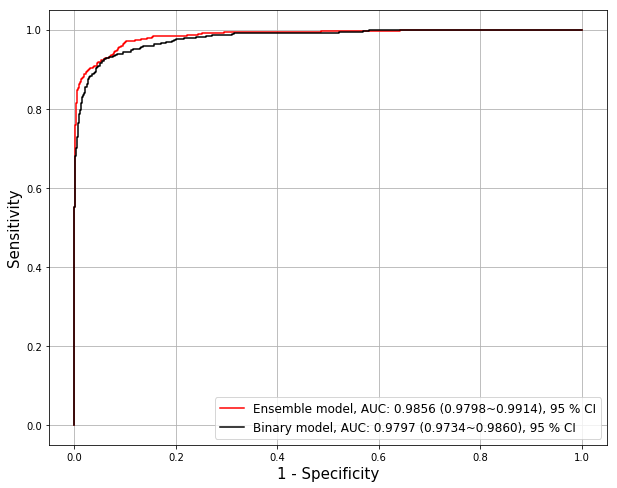

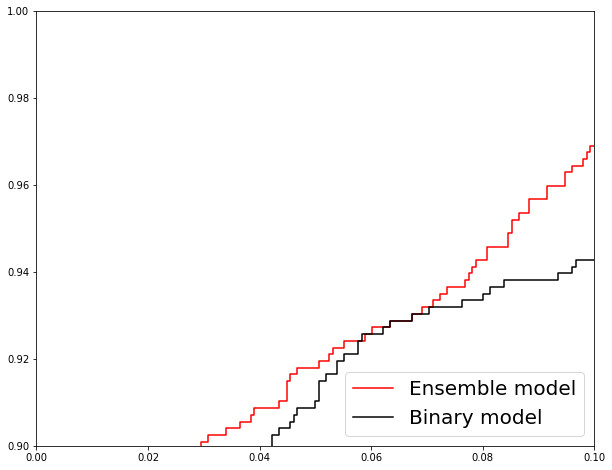

In [38]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):

    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

labels = np.vstack([neg_label, h_label, d_label])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

labels, b_outputs, e_outputs = tri_shuffle(labels, b_outputs, e_outputs)

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [39]:
e_CM, b_CM = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):
    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

In [40]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [41]:
b_metrices

array([[0.91928251, 1.        , 0.88535032, 1.        , 0.78571429],
       [0.9058296 , 0.98484848, 0.87261146, 0.99275362, 0.76470588],
       [0.90950226, 0.95384615, 0.89102564, 0.97887324, 0.78481013],
       [0.89140271, 0.92307692, 0.87820513, 0.96478873, 0.75949367],
       [0.92272727, 0.953125  , 0.91025641, 0.97931034, 0.81333333],
       [0.86818182, 0.921875  , 0.84615385, 0.96350365, 0.71084337],
       [0.88181818, 0.9375    , 0.85897436, 0.97101449, 0.73170732],
       [0.87272727, 0.953125  , 0.83974359, 0.97761194, 0.70930233],
       [0.88181818, 0.953125  , 0.8525641 , 0.97794118, 0.72619048],
       [0.90909091, 0.9375    , 0.8974359 , 0.97222222, 0.78947368]])

In [42]:
e_metrices

array([[0.93721973, 0.93939394, 0.93630573, 0.97350993, 0.86111111],
       [0.94618834, 0.93939394, 0.94904459, 0.97385621, 0.88571429],
       [0.95022624, 0.93846154, 0.95512821, 0.97385621, 0.89705882],
       [0.92760181, 0.93846154, 0.92307692, 0.97297297, 0.83561644],
       [0.96363636, 0.9375    , 0.97435897, 0.97435897, 0.9375    ],
       [0.94090909, 0.9375    , 0.94230769, 0.97350993, 0.86956522],
       [0.91363636, 0.90625   , 0.91666667, 0.95973154, 0.81690141],
       [0.93636364, 0.90625   , 0.94871795, 0.96103896, 0.87878788],
       [0.92272727, 0.890625  , 0.93589744, 0.95424837, 0.85074627],
       [0.92272727, 0.90625   , 0.92948718, 0.9602649 , 0.84057971]])

In [43]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 89.62 (88.22 ~ 91.02)
Sen --- 95.18 (93.40 ~ 96.96)
Spec --- 87.32 (85.65 ~ 89.00)
NPV --- 97.78 (96.96 ~ 98.60)
PPV --- 75.76 (73.16 ~ 78.36)

Ensemble model
Accr --- 93.61 (92.54 ~ 94.68)
Sen --- 92.40 (91.03 ~ 93.77)
Spec --- 94.11 (92.91 ~ 95.31)
NPV --- 96.77 (96.21 ~ 97.34)
PPV --- 86.74 (84.25 ~ 89.22)


### Equal-Variance Test

In [44]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.602, pvalue=0.437814773735
bartlett test for sensitivity: 0.561, pvalue=0.453806727324
bartlett test for specificity: 0.929, pvalue=0.335046228507
bartlett test for negative predictive values: 1.136, pvalue=0.286400636640
bartlett test for positive predictive values: 0.017, pvalue=0.895461425751


In [45]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 2.134, pvalue=0.161322054637
levene test for sensitivity: 0.105, pvalue=0.750185912236
levene test for specificity: 1.677, pvalue=0.211710785023
levene test for negative predictive values: 0.313, pvalue=0.582782049462
levene test for positive predictive values: 0.174, pvalue=0.681341683126


### Normality Test

In [46]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.800, pvalue=0.002056766763
Kolmogorov-Smirnov test for sensitivity: 0.600, pvalue=0.052447552448
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 0.600, pvalue=0.052447552448
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.000010825088


### Wilcoxon signed-ranks test (not normal and paired group)

In [47]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for sensitivity: 4.500, pvalue=0.018903543011
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.005033508201
wilcoxon signed-ranks test for negative predictive values: 7.000, pvalue=0.036657928672
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [48]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -7.032, pvalue=0.000061029270
t-statistics for sensitivity: 3.144, pvalue=0.011848371861
t-statistics for specificity: -9.076, pvalue=0.000007967458
t-statistics for negative predictive values: 2.582, pvalue=0.029611938403
t-statistics for positive predictive values: -9.179, pvalue=0.000007268427


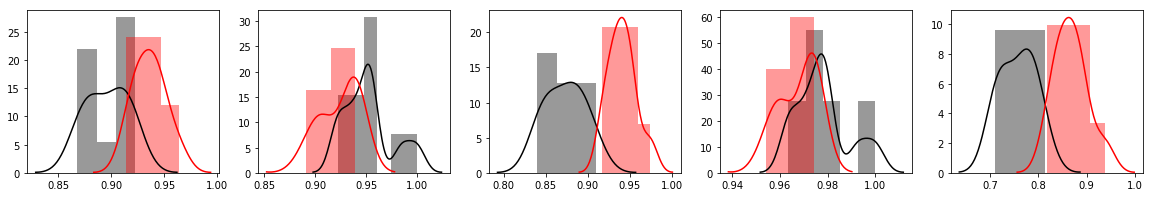

In [49]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()